<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_9_Intersection_Over_Union.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

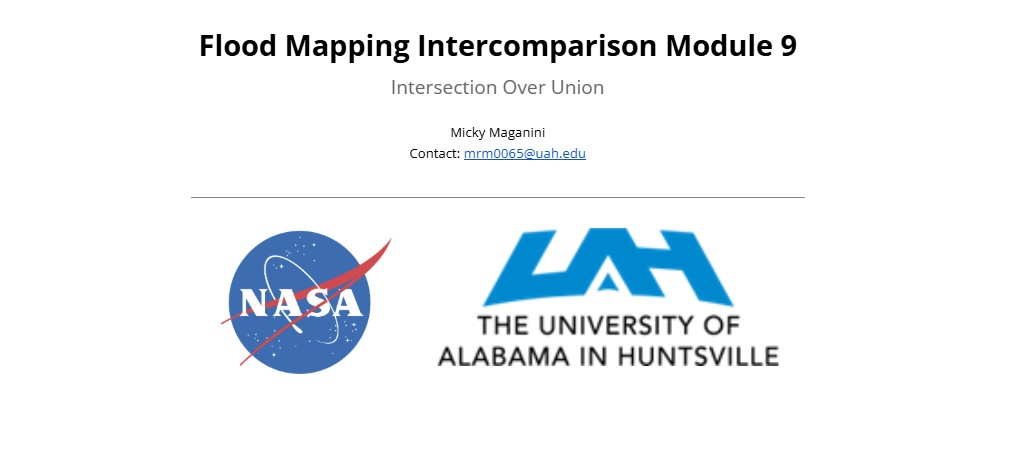


In this notebook, we will calculate the intersection over union for different pairs of flood products. Intersection over Union (IoU) is caclulated between two maps, A and B, and is defined as

$IoU = \frac{Intersection}{Union}$,

where intersection is the amount of pixels which both maps have identified as positive, and union is the amount of pixels which either map A OR map B has identified as positive. In this case, "positive" refers to water pixels.

If we have access to all 7 maps, we will calculate 21 Intersection over Union calculations. Depending on the number of pixels, this can take a very long time (usually about one hour). Thus, it is unlikely that you will be able to run all 21 calculations in one day. To save your data, skip to Step 8 to write our calculations to a CSV.

# Step 1: Import packages

In [ ]:
import ee
import geemap
from google.colab import drive
import os
import glob
from osgeo import gdal
import numpy as np
import pandas as pd
import time
import csv

In [ ]:
ee.Authenticate()

ee.Initialize(project='servir-sco-assets')

# MODIFIABLE VARIABLE ALERT

In [ ]:
my_gee_folder = "users/mickymags/semi_fmi_arkansas_20250409/"
#my_Gdrive_folder = "/content/drive/MyDrive/Flood_Intercomparison/Case_Studies/confirmed_case_studies/cambodia_20241001/"
other_Gdrive_folder = "/content/drive/MyDrive/Flood_Intercomparison/Case_Studies/Flood_Intercomparison/"
flood_event_desc = 'Arkansas'
time_id = '06251109'                # put in a string correlating to the current time which you are running the code -- will help with identifying exports
filename = 'smfnl_iou.csv'

In [ ]:
aoi = ee.FeatureCollection(my_gee_folder + "aoi")
roi = aoi.geometry()
aoi_centroid = aoi.geometry().centroid()             # Get the center of the AOI
lon = aoi_centroid.coordinates().get(0).getInfo()    # Extract the longitude from the centroid
lat = aoi_centroid.coordinates().get(1).getInfo()    # Extract the latitude from the centroid

# Step 1: Import data from Google Earth Engine

In [ ]:
dswxhls = ee.Image(my_gee_folder + 'dswxhls_harmonized')
dswxs1 = ee.Image(my_gee_folder + 'dswxs1_harmonized')
gfm = ee.Image(my_gee_folder + 'gfm_resampled_harmonized')
hydrafloods = ee.Image(my_gee_folder + 'hydrafloods_harmonized')
mcdwd = ee.Image(my_gee_folder + 'mcdwd_resampled_harmonized')
vfm = ee.Image(my_gee_folder + 'vfm_resampled_harmonized')
aoi = ee.FeatureCollection(my_gee_folder + "aoi")

In [ ]:
# Checkf if HYDROSAR is 30 meters
hydrosar_original = ee.Image(my_gee_folder + 'hydrosar_harmonized')

hydrosar_og_scale = hydrosar_original.projection().nominalScale().getInfo()
if hydrosar_og_scale != 30:
  hydrosar = ee.Image(my_gee_folder + 'hydrosar_resampled_harmonized')
else:
  hydrosar = ee.Image(my_gee_folder + 'hydrosar_harmonized')

# Sanity Check to make sure all products have a pixel size of 30 meters

In [ ]:
dswxhls_scale = dswxhls.projection().nominalScale().getInfo()
dswxs1_scale = dswxs1.projection().nominalScale().getInfo()
gfm_scale = gfm.projection().nominalScale().getInfo()
hydrafloods_scale = hydrafloods.projection().nominalScale().getInfo()
mcdwd_scale = mcdwd.projection().nominalScale().getInfo()
vfm_scale = vfm.projection().nominalScale().getInfo()
hydrosar_scale = hydrosar.projection().nominalScale().getInfo()

mybool = dswxhls_scale == dswxs1_scale == gfm_scale == hydrafloods_scale == mcdwd_scale == vfm_scale == hydrosar_scale
if mybool == True:
  print("All products have a resolution of 30 meters, you are ready to go!")
else:
  print("Something went wrong. One of your products does not have a pixel size of 30 meters. \n Print dswxhls_scale, dswxs1_scale, etc. to the console to see which one it is.")

All products have a resolution of 30 meters, you are ready to go!


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.chdir(other_Gdrive_folder)

In [ ]:
pwd

'/content/drive/MyDrive/Flood_Intercomparison/Case_Studies/Flood_Intercomparison'

In [ ]:
#mydesc = a string of the time you submitted
def iou(img1, img2, desc1, desc2, aoi, myproj, mydesc):   #num_pixels
  img1_renamed = img1.rename(desc1)
  img2_renamed = img2.rename(desc2)
  id = flood_event_desc + '_' + desc1 + '_' + desc2

  combo = img1_renamed.addBands(img2_renamed)

  # Add a random number to the end of the export string
  #random = np.random.randint(1e7)
  #randstr = str(random)

  # Tile aoi
  covering_grid = aoi.geometry().coveringGrid(myproj, 2e5)

  num_tiles = covering_grid.size().getInfo()

  for j in range(num_tiles):
    my_tile = ee.Feature(covering_grid.toList(num_tiles).get(j))
    my_tile_clipped = my_tile.geometry().intersection(aoi, 0.001)
    tile_id = str(j)
    tile_export_string = 'iou_'+desc1 + '_and_' + desc2 + '_' + mydesc + 'pt' + tile_id

    sample = combo.sample(
      region= my_tile_clipped,
      scale=30,
      projection = myproj,
      numPixels = 1e13#num_pixels
    )

    #export_string = 'iou_'+desc1 + '_and_' + desc2 + '_' + randstr

    print('sampling...')

    geemap.ee_export_vector_to_drive(
        collection=sample,
        description= tile_export_string,
        fileFormat='CSV',
        folder='Flood_Intercomparison',
        selectors = [desc1, desc2]
    )

  print('sleeping...')
  time.sleep(60)
  print('still sleeping...')
  time.sleep(120)
  print('still sleeping...')
  time.sleep(600)
  print('still sleeping...')
  time.sleep(300)
  print("I'm awake!")

  # For each tile

  dataframes = []
  combined_dataframe = pd.DataFrame()

  for k in range(num_tiles):
    #Read file in
    another_id = str(k)
    tile_input_string = 'iou_'+desc1 + '_and_' + desc2 + '_'  + mydesc + 'pt' + another_id
    data = pd.read_csv(tile_input_string + '.csv')
    combined_dataframe = pd.concat([combined_dataframe, data])
    #dataframes.append(data)
    ######
  #data = pd.read_csv(export_string + '.csv')

  intersection = 0
  union = 0

  print('calculating iou...')

  #num_rows = int(num_pixels - 1)
  num_rows = int(np.floor(combined_dataframe.size / 2))
  print(num_rows)

  for j in range(num_rows):
    row = combined_dataframe.iloc[j]
    feat1 = row[desc1]
    feat2 = row[desc2]

    perc = j * 100 / num_rows

    if j % 500000 == 0:
      print('iou calculation is {0:0.1f} % complete'.format(perc))

    if feat1 == 2 or feat2 == 2:
      continue
    if feat1 == 1 and feat2 == 1:
      intersection += 1
    if feat1 == 1 or feat2 == 1:
      union += 1

  return [id, intersection/union]

In [ ]:
my_proj_code = gfm.projection().getInfo()['crs']

In [ ]:
my_proj_code

'EPSG:32616'

In [ ]:
pwd

'/content/drive/MyDrive/Flood_Intercomparison/Case_Studies/Flood_Intercomparison'

Because this code takes a long time to run, we will write the data to the file at the end of every code cell. Uncomment the cell below if you haven't output code to this file yet.

In [ ]:
#headers = ['Description', 'IOU']
#
#with open(filename, 'w') as csvfile:
#  csvwriter = csv.writer(csvfile)
#  csvwriter.writerow(headers)

# Step 2: DSWx-HLS versus all

In [ ]:
dswxhls_dswxs1_iou = iou(dswxhls, dswxs1, 'dswxhls', 'dswxs1', aoi, my_proj_code, time_id)

sampling...
Exporting iou_dswxhls_and_dswxs1_06251109pt0... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_dswxhls_and_dswxs1_06251109pt1... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_dswxhls_and_dswxs1_06251109pt2... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_dswxhls_and_dswxs1_06251109pt3... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_dswxhls_and_dswxs1_06251109pt4... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_dswxhls_and_dswxs1_06251109pt5... Please check the Task Manager from the JavaScript Code Editor.
sleeping...
still sleeping...
still sleeping...
still sleeping...


In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxhls_dswxs1_iou)

In [ ]:
dswxhls_gfm_iou = iou(dswxhls, gfm, 'dswxhls', 'gfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxhls_gfm_iou)

In [ ]:
dswxhls_hydrafloods_iou = iou(dswxhls, hydrafloods, 'dswxhls', 'hydrafloods', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxhls_hydrafloods_iou)

In [ ]:
dswxhls_hydrosar_iou = iou(dswxhls, hydrosar, 'dswxhls', 'hydrosar', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxhls_hydrosar_iou)

In [ ]:
dswxhls_mcdwd_iou = iou(dswxhls, mcdwd, 'dswxhls', 'mcdwd', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxhls_mcdwd_iou)

In [ ]:
dswxhls_vfm_iou = iou(dswxhls, vfm, 'dswxhls', 'vfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxhls_vfm_iou)

# Step 3: DSWx-S1 versus all (minus DSWx-HLS)

In [ ]:
dswxs1_gfm_iou = iou(dswxs1, gfm, 'dswxs1', 'gfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxs1_gfm_iou)

In [ ]:
dswxs1_hydrafloods_iou = iou(dswxs1, hydrafloods, 'dswxs1', 'hydrafloods', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxs1_hydrafloods_iou)

In [ ]:
dswxs1_hydrosar_iou = iou(dswxs1, hydrosar, 'dswxs1', 'hydrosar', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxs1_hydrosar_iou)

In [ ]:
dswxs1_mcdwd_iou = iou(dswxs1, mcdwd, 'dswxs1', 'mcdwd', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxs1_mcdwd_iou)

In [ ]:
dswxs1_vfm_iou = iou(dswxs1, vfm, 'dswxs1', 'vfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(dswxs1_vfm_iou)

# Step 4: GFM Versus all (minus DSWx-S1 and DSWx-HLS)

In [ ]:
gfm_hydrafloods_iou = iou(gfm, hydrafloods, 'gfm', 'hydrafloods', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(gfm_hydrafloods_iou)

In [ ]:
gfm_hydrosar_iou = iou(gfm, hydrosar, 'gfm', 'hydrosar', aoi, my_proj_code, time_id)

sampling...
Exporting iou_gfm_and_hydrosar_06250959pt0... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_hydrosar_06250959pt1... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_hydrosar_06250959pt2... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_hydrosar_06250959pt3... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_hydrosar_06250959pt4... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_hydrosar_06250959pt5... Please check the Task Manager from the JavaScript Code Editor.
sleeping...
still sleeping...
still sleeping...
still sleeping...
I'm awake!
calculating iou...
107540951
iou calculation is 0.0 % complete
iou calculation is 0.5 % complete
iou calculation is 0.9 % complete
iou calculation is 1.4 % complete
iou calculation is 1.9 % complet

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(gfm_hydrosar_iou)

In [ ]:
gfm_mcdwd_iou = iou(gfm, mcdwd, 'gfm', 'mcdwd', aoi, my_proj_code, time_id)

sampling...
Exporting iou_gfm_and_mcdwd_06250959pt0... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_mcdwd_06250959pt1... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_mcdwd_06250959pt2... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_mcdwd_06250959pt3... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_mcdwd_06250959pt4... Please check the Task Manager from the JavaScript Code Editor.
sampling...
Exporting iou_gfm_and_mcdwd_06250959pt5... Please check the Task Manager from the JavaScript Code Editor.
sleeping...


KeyboardInterrupt: 

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(gfm_mcdwd_iou)

In [ ]:
gfm_vfm_iou = iou(gfm, vfm, 'gfm', 'vfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(gfm_vfm_iou)

# Step 5: HYDRAFloods

In [ ]:
hydrafloods_hydrosar_iou = iou(hydrafloods, hydrosar, 'hydrafloods', 'hydrosar', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(hydrafloods_hydrosar_iou)

In [ ]:
hydrafloods_mcdwd_iou = iou(hydrafloods, mcdwd, 'hydrafloods', 'mcdwd', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(hydrafloods_mcdwd_iou)

In [ ]:
hydrafloods_vfm_iou = iou(hydrafloods, vfm, 'hydrafloods', 'vfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(hydrafloods_vfm_iou)

# Step 6: HYDROSAR

In [ ]:
hydrosar_mcdwd_iou = iou(hydrosar, mcdwd, 'hydrosar', 'mcdwd', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(hydrosar_mcdwd_iou)

In [ ]:
hydrosar_vfm_iou = iou(hydrosar, vfm 'hydrosar', 'vfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(hydrosar_vfm_iou)

# Step 7: MCDWD

In [ ]:
mcdwd_vfm_iou = iou(mcdwd, vfm, 'mcdwd', 'vfm', aoi, my_proj_code, time_id)

In [ ]:
with open(filename, 'a') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(mcdwd_vfm_iou)